# Sweep a option in QComponent, get Ansys HFSS driven-modal scatter matrix, impedance matrix, and admittance matrix.

# Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr
from qiskit_metal.analyses.sweep_options.sweeping import Sweeping

## Create the design in Metal
 Set up a design of a given dimension.  Create a design by specifying the chip size and open Metal GUI.  Dimensions will be respected in the design rendering.  Note the chip design is centered at origin (0,0).

In [3]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

# Perform the necessary imports.
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

In [4]:
# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Add 2 transmons to the design.
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width='425 um',
    pocket_height='650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(a=dict(loc_W=+1, loc_H=+1),
                         b=dict(loc_W=-1, loc_H=+1, pad_height='30um'),
                         c=dict(loc_W=+1, loc_H=-1, pad_width='200um'),
                         d=dict(loc_W=-1, loc_H=-1, pad_height='50um')))

## Create 2 transmons
q1 = TransmonPocket(design,
                    'Q1',
                    options=dict(pos_x='+1.4mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))
q2 = TransmonPocket(design,
                    'Q2',
                    options=dict(pos_x='-0.6mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))

gui.rebuild()
gui.autoscale()

In [6]:
# Add 2 hangers consisting of capacitively coupled transmission lines.
TQ1 = CoupledLineTee(design,
                     'TQ1',
                     options=dict(pos_x='1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))
TQ2 = CoupledLineTee(design,
                     'TQ2',
                     options=dict(pos_x='-1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))

gui.rebuild()
gui.autoscale()

In [7]:
# Add 2 meandered CPWs connecting the transmons to the hangers.
ops = dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(total_length='8mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                               pin='second_end'),
                                end_pin=Dict(component='Q1', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

options2 = Dict(total_length='9mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                               pin='second_end'),
                                end_pin=Dict(component='Q2', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale() 

In [8]:
# Add 2 open to grounds at the ends of the horizontal CPW.
otg1 = OpenToGround(design, 'otg1', options=dict(pos_x='3mm', pos_y='3mm'))
otg2 = OpenToGround(design,
                    'otg2',
                    options=dict(pos_x='-3mm', pos_y='3mm', orientation='180'))

gui.rebuild()
gui.autoscale()

# Add 3 straight CPWs that comprise the long horizontal CPW.

ops_oR = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ1', pin='prime_end'),
                              end_pin=Dict(component='otg1', pin='open')))
ops_mid = Dict(hfss_wire_bonds=True,
               pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                              pin='prime_start'),
                               end_pin=Dict(component='TQ2', pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                             pin='prime_start'),
                              end_pin=Dict(component='otg2', pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

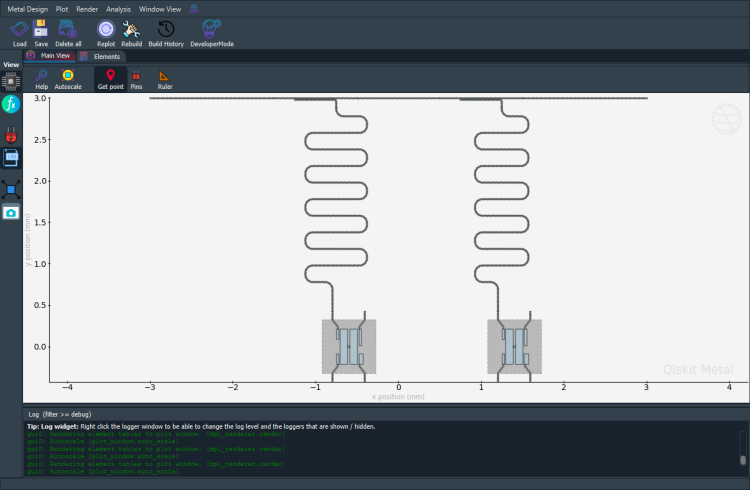

In [9]:
gui.screenshot()

## 2. Render the qubit from Metal into the HangingResonators design in Ansys. <br>Must open Ansys HFSS at this point. 

**Wait for Ansys to fully open before proceeding.**<br> If necessary, also close any Ansys popup windows.

### Registration occurs automatically within the method "sweep_one_option_get_drivenmodal_solution_data". 

### Must have an open Ansys project and HFSS eigenmode design before executing render_design. Can do it manually or automate it. 

Manually: To create a new Ansys project, click "New", the leftmost icon right below the file menu. 

Automate: Execute the command <hfss.open_ansys()> in cell below only if Ansys is not already open.  Use the cells below to open the Ansys application.  

### The method "sweep_one_option_get_drivenmodal_solution_data" will connect to ansys, activate a HFSS design, add a setup, and insert frequency-sweep under the setup.

In [10]:
#Reference to Ansys hfss QRenderer
hfss = design.renderers.hfss

# This cell will open the Ansys application.  Run this cell, if Ansys, is not already open.
# A project will be opened using this command.
#hfss.open_ansys()

In [11]:
sweep = Sweeping(design)

In [12]:
# Set the buffer width at the edge of the design to be 0.5 mm 
# in both directions.

hfss.options['x_buffer_width_mm'] = 0.5
hfss.options['y_buffer_width_mm'] = 0.5

As a reminder, arguments for render_design() are given as: <br>

First parameter: List of components to render (empty list if rendering whole Metal design) <br><br>
Second parameter: List of pins (qcomp, pin) with open endcaps <br><br>
Third parameter: List of pins (qcomp, pin, impedance) to render as lumped ports <br><br>
Fourth parameter: List of junctions (qcomp, qgeometry_name, impedance, draw_ind)
       to render as lumped ports or as lumped port in parallel with a sheet inductance <br><br>
Fifth parameter: List of junctions (qcomp, qgeometry_name) to omit altogether during rendering<br><br>
Sixth parameter: Whether to render chip via box plus buffer or fixed chip size<br>


The size scatter square matrix, impedance square matrix, and admittance square matrix is determined by size of (3rd parameter) + (size of fourth parameter) of render_design.  

In [13]:
selection = [] # Means to render everything in qgeometry table.
open_pins = []

# Here, pin cpw_openRight_end and cpw_openLeft_end are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('cpw_openRight', 'end', 50),
                      ('cpw_openLeft', 'end', 50)]
jj_to_port = [('Q1', 'rect_jj', 50, False)]
# Neither of the junctions in Q1 or Q2 are rendered.
ignored_jjs = [('Q2', 'rect_jj')]
box_plus_buffer = True

dm_render_args = Dict(selection=selection,
                      open_pins=open_pins,
                      port_list=port_list,
                      jj_to_port=jj_to_port,
                      ignored_jjs=ignored_jjs,
                      box_plus_buffer=box_plus_buffer)

In [14]:
# Pass a dict with arguments to be used add Setup to project.
# If you don't pass all the arguments, the default is determined by
# QHFSSRenderer's default_options.
# The name of setup will be "Sweep_dm_setup".
# If a setup named "Sweep_dm_setup" exists in the project, it will be deleted,
# and a new setup will be added with the arguments from setup_args.
hfss_dm_setup_args = Dict(freq_ghz=None,
                          max_delta_s=None,
                          max_passes=None,
                          min_passes=None,
                          min_converged=None,
                          pct_refinement=None,
                          basis_order=None)
# Example of updating the keys that we are interested in.
hfss_dm_setup_args = Dict(
    freq_ghz=6.0,
    max_delta_s=0.05,
    max_passes=12,
    min_passes=2,
)



Add a frequency sweep to a driven modal setup.<br>
From QHFSSRenderer.add_sweep doc_strings.  Please go to doc_strings to get the latest information.  

Args:<br>
    setup_name (str, optional): Name of driven modal simulation setup.
                            Defaults to "Setup".<br>
    start_ghz (float, optional): Starting frequency of sweep in GHz.
                            Defaults to 2.0.<br>
    stop_ghz (float, optional): Ending frequency of sweep in GHz.
                            Defaults to 8.0.<br>
    count (int, optional): Total number of frequencies.
                            Defaults to 101.<br>
    step_ghz (float, optional): Difference between adjacent
                            frequencies. Defaults to None.<br>
    name (str, optional): Name of sweep. Defaults to "Sweep".<br>
    type (str, optional): Type of sweep. Defaults to "Fast".<br>
    save_fields (bool, optional): Whether or not to save fields.
                        Defaults to False.<br>
                        
                        
From pyEPR.HfssSetup.insert_sweep(), please go to this method to get the latest documentation.   
You should provide either step_ghz or count when inserting an HFSS driven model freq sweep. Do not provide both or neither!

In [15]:
dm_add_sweep_args = Dict(name="Sweep_options__dm_sweep",
                         start_ghz=4.0,
                         stop_ghz=8.0,
                         count=2001,
                         type="Interpolating")

In [16]:
all_sweeps, return_code = sweep.sweep_one_option_get_drivenmodal_solution_data(
    meanderQ1.name,
    'total_length', ['9mm', '8mm', '7mm'],
    dm_render_args,
    setup_args=hfss_dm_setup_args,
    dm_add_sweep_args=dm_add_sweep_args,
    leave_last_design=True)

INFO 11:44AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:44AM [load_ansys_project]: 	Opened Ansys App
INFO 11:44AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 11:44AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project10
INFO 11:44AM [connect_design]: No active design found (or error getting active design).
INFO 11:44AM [connect]: 	 Connected to project "Project10". No design detected
11:44AM 18s WARNING [activate_drivenmodal_design]: The name=Sweep_DrivenModal was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 11:44AM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal [Solution type: DrivenModal]
WARNING 11:44AM [connect_setup]: 	No design setup detected.
WARNING 11:44AM [connect_setup]: 	Creating drivenmodal default setup.
INFO 11:44AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 11:44AM [get_setup]: 	O

In [17]:
# Each key corresponds to list passed to ['9mm', '8mm', '7mm']
if return_code == 0:
    print(all_sweeps.keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')


dict_keys(['9mm', '8mm', '7mm'])


In [18]:
all_sweeps['9mm']['option_name']


'total_length'

In [19]:
# For each key, know if the solution data converged.
if return_code == 0:
    for item in all_sweeps.keys():
        option_name = all_sweeps[item]['option_name']
        did_converge = all_sweeps[item]['convergence']
        print(f'For {option_name}={item}, convergence is {did_converge}.')
else:
    print('Check warning messages to see why all_sweeps is non-zero.')  

For total_length=9mm, convergence is True.
For total_length=8mm, convergence is True.
For total_length=7mm, convergence is True.


In [20]:
# For example, just one group of solution data. Look at convergence data.
if return_code == 0:
    print(all_sweeps['9mm']['convergence_t'])
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

             Solved Elements  Max Mag. Delta S
Pass Number                                   
1                      11241               NaN
2                      14620          0.863890
3                      19005          0.325750
4                      24703          0.206030
5                      32112          0.148490
6                      41025          0.104610
7                      53086          0.063663
8                      69016          0.040936
9                      89721          0.027670
10                    116638          0.018576


In [21]:
# Each values use for the given option, has three matrixes:  
# scatter, impedance, and admittance.
if return_code == 0:
    print(all_sweeps['9mm'].keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

dict_keys(['option_name', 'convergence', 's_matrix', 'y_matrix', 'z_matrix', 'convergence_t'])


In [22]:
# For example, just one group of solution data. 
if return_code == 0:
    print(all_sweeps['9mm']['z_matrix'])
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

                       Z11                  Z21                 Z31  \
4.000  0.000000-13.223613j  0.000000+47.341519j  0.000000+0.046089j   
4.002  0.000005-13.191918j -0.000013+47.332791j  0.000000+0.046377j   
4.004  0.000011-13.160234j -0.000025+47.324086j  0.000000+0.046670j   
4.006  0.000016-13.128562j -0.000037+47.315404j  0.000000+0.046966j   
4.008  0.000021-13.096900j -0.000049+47.306743j  0.000000+0.047265j   
...                    ...                  ...                 ...   
7.992  0.000035+71.832199j  0.000037+85.668997j  0.000067-0.041799j   
7.994  0.000026+71.935858j  0.000028+85.757537j  0.000051-0.041888j   
7.996  0.000018+72.039731j  0.000018+85.846296j  0.000035-0.041978j   
7.998  0.000009+72.143820j  0.000009+85.935276j  0.000018-0.042067j   
8.000 -0.000000+72.248125j -0.000000+86.024477j  0.000000-0.042157j   

                       Z12                  Z22                 Z32  \
4.000 -0.000000+47.341519j  0.000000-13.058514j -0.000000-0.023440j   
4.002

In [23]:
if return_code == 0:
    df_s = all_sweeps['9mm']['s_matrix']
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

In [24]:
df_s['20_log_of_mag_S11']= 20 * np.log10(np.absolute(df_s['S11']))
df_s['20_log_of_mag_S21']= 20 * np.log10(np.absolute(df_s['S21']))
df_s['20_log_of_mag_S31']= 20 * np.log10(np.absolute(df_s['S31']))

# Reference to current axis. 
magnitude = plt.figure('Magnitude S11, S21, and S31')
plt.clf()
axis = plt.gca() # Get current axis.
df_s = all_sweeps['9mm']['s_matrix']
df_s.plot(kind = 'line', y='20_log_of_mag_S11', color = 'green', ax = axis)
df_s.plot(kind = 'line', y='20_log_of_mag_S21', color = 'blue', ax = axis)
df_s.plot(kind = 'line', y='20_log_of_mag_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Magnitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'|S11|,|S21|,|S31| [dB]')
magnitude.show()

In [25]:
# Data is shown as degrees.  
# However, if you want radians, change value of deg to false, deg=False.
df_s['degrees_S11'] = np.angle(df_s['S11'], deg=True)
df_s['degrees_S21'] = np.angle(df_s['S21'], deg=True)
df_s['degrees_S31'] = np.angle(df_s['S31'], deg=True)

# Reference to current axis. 
phase = plt.figure('Phase of S11 and S21')
plt.clf()
axis = plt.gca() # Get current axis.
df_s = all_sweeps['9mm']['s_matrix']
df_s.plot(kind = 'line', y='degrees_S11', color = 'green', ax = axis)
df_s.plot(kind = 'line', y='degrees_S21', color = 'blue', ax = axis)
df_s.plot(kind = 'line', y='degrees_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Phase')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'<S11, <S21, <S31 [degrees]')
phase.show()

In [26]:
# In HFSS, after the last sweep, should the design be cleared?  The argument "leave_last_design" is true by default. 
# If you want to delete after last sweep, change argument to false.

leave_last_design = False

all_sweeps, return_code = sweep.sweep_one_option_get_drivenmodal_solution_data(
    meanderQ1.name,
    'total_length', ['9mm', '8mm', '7mm'],
    dm_render_args,
    setup_args=hfss_dm_setup_args,
    dm_add_sweep_args=dm_add_sweep_args,
    leave_last_design=leave_last_design)

INFO 11:59AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:59AM [load_ansys_project]: 	Opened Ansys App
INFO 11:59AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 11:59AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project10
INFO 11:59AM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal [Solution type: DrivenModal]
INFO 11:59AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 11:59AM [connect]: 	Connected to project "Project10" and design "Sweep_DrivenModal" 😀 

INFO 11:59AM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal [Solution type: DrivenModal]
INFO 11:59AM [get_setup]: 	Opened setup `Sweep_dm_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 12:00PM [get_setup]: 	Opened setup `Sweep_dm_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 12:00PM [get_setup]: 	Opened setup `Sweep_dm_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 12:00PM [analyze]: Ana

In [27]:
# Uncomment next line if you would like to close the gui
# gui.main_window.close()